In [1]:
#!pip3 install pandas
#!pip3 install xgboost
#!pip3 install sklearn
#!pip3 install six==1.10
#!pip3 install matplotlib
#!pip3 install statsmodels
#!pip3 install keras==2.2
#!pip3 install tensorflow
#!pip3 install np_utils
#!pip3 install opencv-python
#!pip3 install optunity
#!pip3 install pydot-ng
#!pip3 install pydot
#!pip3 install tensorboard
#!pip3 uninstall pyparsing -f -y
#!pip3 install --ignore-installed -U ipython
#!pip3 install pyparsing
#!pip3 install graphviz
#!pip3 install --ignore-installed pydot>=1.2.4

In [2]:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xgboost as xgb
import math
import random
import pydot

from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost import plot_tree

#from graphviz import Digraph

from sklearn import cross_validation, metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, mutual_info_regression

import statsmodels.api as sm
import cv2
import h5py

from math import sqrt
from scipy.integrate import simps
from scipy.stats import f

import optunity
import optunity.metrics

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GaussianNoise
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from keras.utils import vis_utils as vizu
from keras import callbacks
from keras import backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


In [3]:
pca_flag = True
noise_flag = True

# Load Data

In [4]:
kyoto_1_score = pd.read_csv('dataset/data1_score.csv')

In [5]:
kyoto_1_all = pd.read_csv('dataset/dataset1_15features.csv')

kyoto_1_all.rename(index=str, columns={"Userid": "userid"}, inplace=True)
kyoto_1_all = kyoto_1_all.drop(['Score'], axis=1)

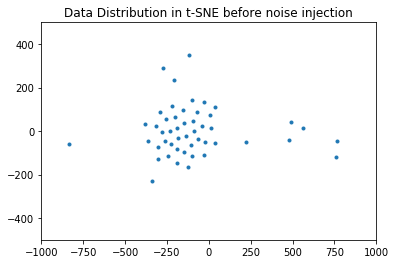

In [6]:
k_temp = kyoto_1_all.drop(['userid'], axis=1)

tsne = TSNE(perplexity =30, n_components=2, init='pca', n_iter=300)
k_temp = tsne.fit_transform(k_temp)

fig, axes = plt.subplots()
axes.set_xlim([-1000, 1000])
axes.set_ylim([-500, 500])
axes.set_title('Data Distribution in t-SNE before noise injection')
axes.plot(k_temp[:,0], k_temp[:,1], '.')

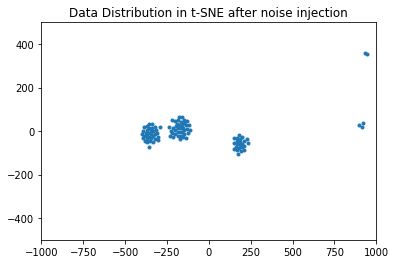

In [7]:
if noise_flag:
    
    k_temp = kyoto_1_all.drop(['userid'], axis=1)

    noise1 = kyoto_1_all[list(k_temp)].mul(np.random.normal(1.0, 0.5, size=len(kyoto_1_all)), axis=0)
    noise1 = noise1.join(kyoto_1_all['userid'].to_frame())

    #noise2 = kyoto_1_all[list(k_temp)].mul(np.random.normal(1.0, 0.5, size=len(kyoto_1_all)), axis=0)
    #noise2 = noise2.join(kyoto_1_all['userid'].to_frame())

    kyoto_1_all = pd.concat([kyoto_1_all, noise1])
    #kyoto_1_all = pd.concat([kyoto_1_all, noise2])

    k_temp = kyoto_1_all.drop(['userid'], axis=1)
    k_temp = tsne.fit_transform(k_temp)

    fig, axes = plt.subplots()
    axes.set_xlim([-1000, 1000])
    axes.set_ylim([-500, 500])
    axes.set_title('Data Distribution in t-SNE after noise injection')
    axes.plot(k_temp[:,0], k_temp[:,1], '.')


# Merge Datasets

In [8]:
kyoto_x_all = pd.merge(kyoto_1_all, kyoto_1_score, on='userid')
kyoto_1 = kyoto_x_all
kyoto_1.fillna(0.0, inplace=True)
kyoto_1 = kyoto_1.drop(['userid'], axis=1)
kyoto_1 = kyoto_1.drop(['Delete_Memo'], axis=1)
kyoto_1 = kyoto_1[kyoto_1['score']>0]

# Preprocess

In [9]:
kyoto_y = kyoto_1['score']
kyoto_x = kyoto_1.drop(['score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(kyoto_x, kyoto_y, test_size=0.3)
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

# Model Specification and Evaluation Funcation

In [10]:
def knn_opt_model():
    
    def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    
    # create model
    model = Sequential()
    model.add(GaussianNoise(stddev=0.1, input_shape=(14,)))
    model.add(Dense(7, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GaussianNoise(0.1))
    model.add(Dense(14, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    #model.compile(loss='mse', optimizer='adam')
    return model

In [11]:
def knn_denoise_model():
    
    def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    
    # create model
    model = Sequential()
    #model.add(GaussianNoise(stddev=0.1, input_shape=(14,)))
    model.add(Dense(7, activation='relu', input_shape=(14,)))
    model.add(Dropout(0.5))
    #model.add(GaussianNoise(0.1))
    model.add(Dense(14, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    #model.compile(loss='mse', optimizer='adam')
    return model

In [12]:
def knn_2hiddenlayer_model():
    
    def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    
    # create model
    model = Sequential()
    #model.add(GaussianNoise(stddev=0.1, input_shape=(14,)))
    model.add(Dense(7, activation='relu', input_shape=(14,)))
    #model.add(Dropout(0.5))
    #model.add(GaussianNoise(0.1))
    model.add(Dense(14, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=root_mean_squared_error, optimizer='adam')
    #model.compile(loss='mse', optimizer='adam')
    return model

In [13]:
def knn_baseline_model():
    
    #def root_mean_squared_error(y_true, y_pred):
    #    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    
    # create model
    model = Sequential()
    #model.add(GaussianNoise(stddev=0.1, input_shape=(14,)))
    model.add(Dense(7, activation='relu', input_shape=(14,)))
    #model.add(Dropout(0.5))
    #model.add(GaussianNoise(0.1))
    #model.add(Dense(14, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    #model.compile(loss=root_mean_squared_error, optimizer='adam')
    model.compile(loss='mse', optimizer='adam')
    return model

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def REC(y_true , y_pred):
    
    Accuracy = []
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_true)):
            
            y_true[j]
            y_pred[j]
            
            np.linalg.norm(y_true[j] - y_pred[j])
            np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]
            
            if np.linalg.norm(y_true[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_true))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon, Accuracy, AUC

In [16]:
def model_evaluate (model, X_train, X_test, y_train, y_test):

    y_pred = model.predict(X_test)
    Deviation, Accuracy, auc = REC(y_test.values, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = ((y_test - y_pred) / y_test).abs().mean()*100
    
    f_test = np.var(y_test) / np.var(y_pred)
    df1 = len(y_test) - 1
    df2 = len(y_pred) - 1
    p_value = 1 - 2 * abs(0.5 - f.cdf(f_test, df1, df2))
    
    p_stars = ''
    if p_value <= 0.05:
        p_stars = '*'
    if p_value <= 0.01:
        p_stars = '**'
    if p_value <= 0.001:
        p_stars = '***'
    #print(F, p_value)
    
    y_validate = model.predict(X_train)
    training_loss = sqrt(mean_squared_error(y_train, y_validate))
    
    return_dict = {'rmse':rmse, 
                   'mape':mape, 
                   'r2':r2, 
                   'auc':auc,
                   'training_loss':training_loss, 
                   'f_test':f_test,
                   'p':p_stars,
                   'y_pred':y_pred, 
                   'y_validate':y_validate}
    
    return return_dict
    

In [17]:
def pca_extraction (X_train, X_test):
    pca = PCA(n_components=9)# adjust yourself
    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)  
    return X_pca_train, X_pca_test

# Keras NN Tuning

In [18]:
matplotlib.rcParams.update({'font.size': 12})
K_epochs = 1000

### Training with 2 hidden layer (without Dropout, Noise and Early-stop)

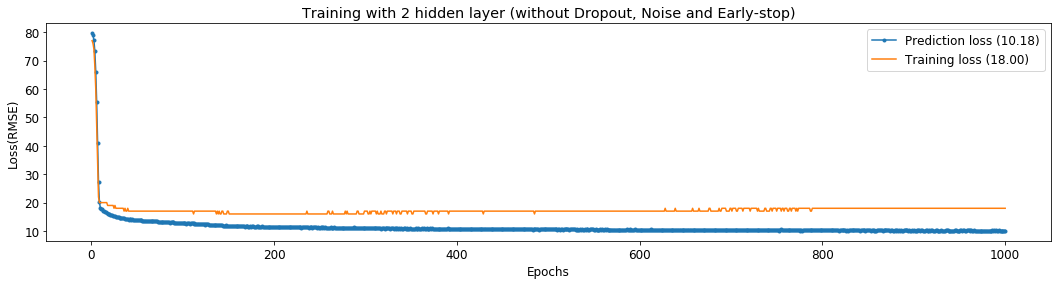

In [19]:
knn = KerasRegressor(build_fn=knn_2hiddenlayer_model, epochs=K_epochs, batch_size=1, verbose=0)

model = knn.fit(X_train, y_train, validation_data=(X_test, y_test))
result_dict = model_evaluate (knn, X_train, X_test, y_train, y_test)

epochs = range(1,len(model.history['loss']) + 1)

#x = np.array(model.history['loss']).astype(float)
#y = np.sqrt(np.abs(x)) * np.sign(x)
#y = np.abs(x) * np.sign(x)

x1 = np.array(model.history['val_loss']).astype(int)
Training_Loss = np.abs(x1) * np.sign(x1)

x2 = np.array(model.history['loss']).astype(float)
RMSE = np.abs(x2) * np.sign(x2)

plt.figure(figsize=(18, 4))
plt.plot(epochs, RMSE, '.-',
        epochs, Training_Loss, '-')
plt.title('Training with 2 hidden layer (without Dropout, Noise and Early-stop)')
plt.xlabel('Epochs')
plt.ylabel('Loss(RMSE)')
plt.legend(['Prediction loss (' + str(format(RMSE[-1], '.2f')) +')', 
            'Training loss (' + str(format(Training_Loss[-1], '.2f')) +')'])
plt.show()

RMSE: 10.18
R2: -0.05
AUC: 0.88
MAPE: 42.85
F-Test: 1.62 
Training Loss: 18.00


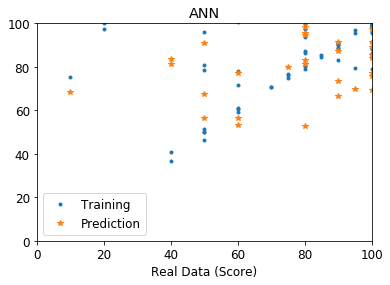

In [20]:
print('RMSE:', str(format(RMSE[-1], '.2f')))
print('R2:', '{:.2f}'.format(result_dict['r2']))
print('AUC:', '{:.2f}'.format(result_dict['auc']))
print('MAPE:', '{:.2f}'.format(result_dict['mape']))
print('F-Test:', '{:.2f}'.format(result_dict['f_test']), result_dict['p'])
print('Training Loss:', str(format(Training_Loss[-1], '.2f')))

plt.plot(y_train, result_dict['y_validate'], '.',
         y_test, result_dict['y_pred'], '*',)
plt.title('ANN')
plt.xlabel('Real Data (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.show()

### Training with Dropout (without Noise and Early-stop)

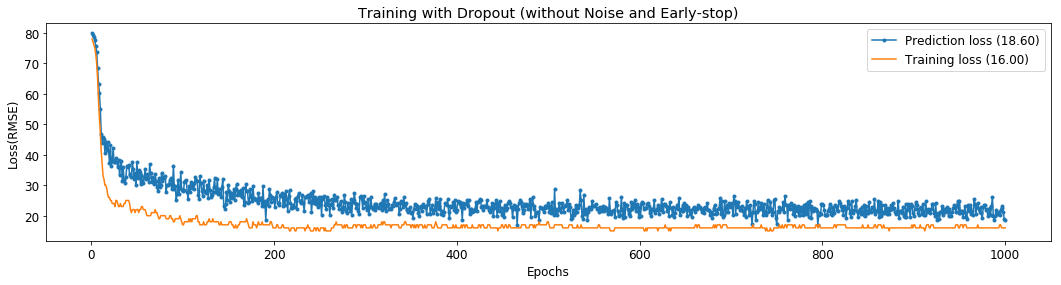

In [21]:
knn = KerasRegressor(build_fn=knn_denoise_model, epochs=K_epochs, batch_size=1, verbose=0)

model = knn.fit(X_train, y_train, validation_data=(X_test, y_test))
result_dict = model_evaluate (knn, X_train, X_test, y_train, y_test)

epochs = range(1,len(model.history['loss']) + 1)

#x = np.array(model.history['loss']).astype(float)
#y = np.sqrt(np.abs(x)) * np.sign(x)
#y = np.abs(x) * np.sign(x)

x1 = np.array(model.history['val_loss']).astype(int)
Training_Loss = np.abs(x1) * np.sign(x1)

x2 = np.array(model.history['loss']).astype(float)
RMSE = np.abs(x2) * np.sign(x2)

plt.figure(figsize=(18, 4))
plt.plot(epochs, RMSE, '.-',
        epochs, Training_Loss, '-')
plt.title('Training with Dropout (without Noise and Early-stop)')
plt.xlabel('Epochs')
plt.ylabel('Loss(RMSE)')
plt.legend(['Prediction loss (' + str(format(RMSE[-1], '.2f')) +')', 
            'Training loss (' + str(format(Training_Loss[-1], '.2f')) +')'])
plt.show()

RMSE: 18.60
R2: 0.10
AUC: 0.89
MAPE: 42.37
F-Test: 15.79 ***
Training Loss: 16.00


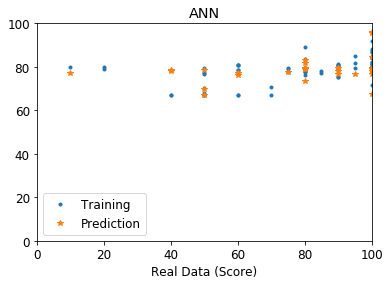

In [22]:
print('RMSE:', str(format(RMSE[-1], '.2f')))
print('R2:', '{:.2f}'.format(result_dict['r2']))
print('AUC:', '{:.2f}'.format(result_dict['auc']))
print('MAPE:', '{:.2f}'.format(result_dict['mape']))
print('F-Test:', '{:.2f}'.format(result_dict['f_test']), result_dict['p'])
print('Training Loss:', str(format(Training_Loss[-1], '.2f')))

plt.plot(y_train, result_dict['y_validate'], '.',
         y_test, result_dict['y_pred'], '*',)
plt.title('ANN')
plt.xlabel('Real Data (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.show()

### Training with Dropout and Noise  (without Early-stop)

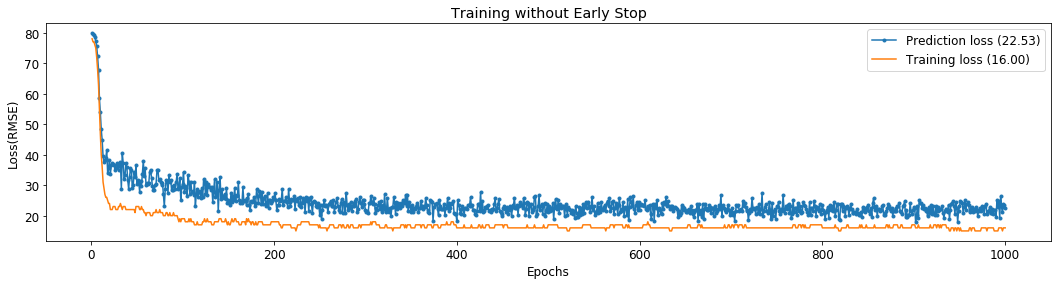

In [23]:
knn = KerasRegressor(build_fn=knn_opt_model, epochs=K_epochs, batch_size=1, verbose=0)

model = knn.fit(X_train, y_train, validation_data=(X_test, y_test))
result_dict = model_evaluate (knn, X_train, X_test, y_train, y_test)

epochs = range(1,len(model.history['loss']) + 1)

#x = np.array(model.history['loss']).astype(float)
#y = np.sqrt(np.abs(x)) * np.sign(x)
#y = np.abs(x) * np.sign(x)

x1 = np.array(model.history['val_loss']).astype(int)
Training_Loss = np.abs(x1) * np.sign(x1)

x2 = np.array(model.history['loss']).astype(float)
RMSE = np.abs(x2) * np.sign(x2)

plt.figure(figsize=(18, 4))
plt.plot(epochs, RMSE, '.-',
        epochs, Training_Loss, '-')
plt.title('Training without Early Stop')
plt.xlabel('Epochs')
plt.ylabel('Loss(RMSE)')
plt.legend(['Prediction loss (' + str(format(RMSE[-1], '.2f')) +')', 
            'Training loss (' + str(format(Training_Loss[-1], '.2f')) +')'])
plt.show()

RMSE: 22.53
R2: 0.15
AUC: 0.88
MAPE: 40.32
F-Test: 13.85 ***
Training Loss: 16.00


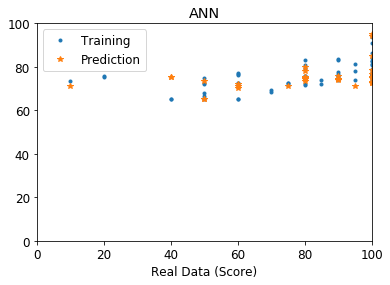

In [24]:
print('RMSE:', str(format(RMSE[-1], '.2f')))
print('R2:', '{:.2f}'.format(result_dict['r2']))
print('AUC:', '{:.2f}'.format(result_dict['auc']))
print('MAPE:', '{:.2f}'.format(result_dict['mape']))
print('F-Test:', '{:.2f}'.format(result_dict['f_test']), result_dict['p'])
print('Training Loss:', str(format(Training_Loss[-1], '.2f')))

plt.plot(y_train, result_dict['y_validate'], '.',
         y_test, result_dict['y_pred'], '*',)
plt.title('ANN')
plt.xlabel('Real Data (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.show()

### Training with 2 hidden layers, Dropout, Noise and Early Stop

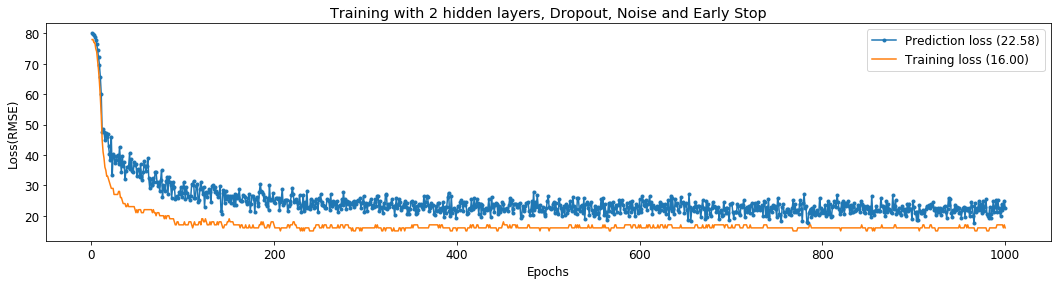

In [38]:
knn = KerasRegressor(build_fn=knn_opt_model, epochs=K_epochs, batch_size=1, verbose=0)

patience = 30

stopper = callbacks.EarlyStopping(monitor='mse', patience=patience, baseline=1000, verbose=1)
model = knn.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stopper])
epochs = range(1,len(model.history['loss']) + 1)

x1 = np.array(model.history['val_loss']).astype(int)
Training_Loss = np.abs(x1) * np.sign(x1)

x2 = np.array(model.history['loss']).astype(float)
RMSE = np.abs(x2) * np.sign(x2)

plt.figure(figsize=(18, 4))
plt.plot(epochs, RMSE, '.-',
        epochs, Training_Loss, '-')
plt.title('Training with 2 hidden layers, Dropout, Noise and Early Stop')
plt.xlabel('Epochs')
plt.ylabel('Loss(RMSE)')
plt.legend(['Prediction loss (' + str(format(RMSE[-1], '.2f')) +')', 
            'Training loss (' + str(format(Training_Loss[-1], '.2f')) +')'])
plt.show()

RMSE: 29.09
R2: 0.15
AUC: 0.88
MAPE: 40.32
F-Test: 13.85 ***
Training Loss: 21.00


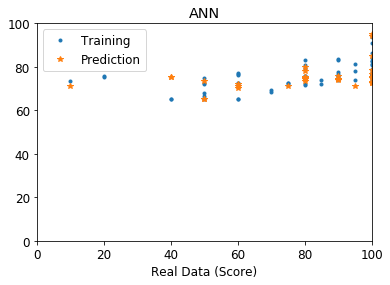

In [33]:
print('RMSE:', str(format(RMSE[-1], '.2f')))
print('R2:', '{:.2f}'.format(result_dict['r2']))
print('AUC:', '{:.2f}'.format(result_dict['auc']))
print('MAPE:', '{:.2f}'.format(result_dict['mape']))
print('F-Test:', '{:.2f}'.format(result_dict['f_test']), result_dict['p'])
print('Training Loss:', str(format(Training_Loss[-1], '.2f')))

plt.plot(y_train, result_dict['y_validate'], '.',
         y_test, result_dict['y_pred'], '*',)
plt.title('ANN')
plt.xlabel('Real Data (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.show()

In [ ]:
'''
x1 = np.array(model.history['val_loss']).astype(int)
#y = np.sqrt(np.abs(x)) * np.sign(x)
y1 = np.abs(x1) * np.sign(x1)

x2 = np.array(model.history['loss']).astype(float)
#y = np.sqrt(np.abs(x)) * np.sign(x)
y2 = np.abs(x2) * np.sign(x2)

plt.figure(figsize=(10, 5))
plt.plot(epochs, y1, '.-',
         epochs, y2, '-')
plt.title('Prediction Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.xlim(0, 200)
plt.legend(['training', 'testing'])
plt.show()
'''

In [ ]:
'''
matplotlib.rcParams.update({'font.size': 12})

plt.figure(figsize=(14, 7))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

label = ['Validation', 'Testing']

plt.subplot(2, 3, 1)
plt.plot(y_train.values, ols_train_y, '.',
         y_test.values, ols_pred_y, '*')
plt.title('MLR')
plt.xlabel('Real Data (Score)')
plt.ylabel('Prediction Result (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.subplot(2, 3, 2)
plt.plot(y_train, regr_train_y, '.',
         y_test, regr_pred_y, '*')
plt.title('CART')
plt.xlabel('Real Data (Score)')
#plt.ylabel('Observation')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.subplot(2, 3, 3)
plt.plot(y_train, svr_train_y, '.',
         y_test, svr_pred_y, '*')
plt.title('SVR')
plt.xlabel('Real Data (Score)')
#plt.ylabel('Observation')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.subplot(2, 3, 4)
plt.plot(y_train, xgr_train_y, '.',
         y_test, xgr_pred_y, '*')
plt.title('XGBoost')
plt.xlabel('Real Data (Score)')
plt.ylabel('Prediction Result (Score)')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.subplot(2, 3, 5)
plt.plot(y_train, mlp_train_y, '.',
         y_test, mlp_pred_y, '*',)
plt.title('ANN')
plt.xlabel('Real Data (Score)')
#plt.ylabel('Observation')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(['Training', 'Prediction'])

plt.show()
'''

![title](./keras_model.png)